In [3]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import numpy as np
import pandas as pd

In [4]:
##################  Загрузка данных
Data1 = pd.read_csv('D:\Coding\data\phone_user_review_file_1.csv', encoding= 'ANSI')
Data2 = pd.read_csv('D:\Coding\data\phone_user_review_file_2.csv', encoding= 'ANSI')
Data3 = pd.read_csv('D:\Coding\data\phone_user_review_file_3.csv', encoding= 'ANSI')
Data4 = pd.read_csv('D:\Coding\data\phone_user_review_file_4.csv', encoding= 'ANSI')
Data5 = pd.read_csv('D:\Coding\data\phone_user_review_file_5.csv', encoding= 'ANSI')
Data6 = pd.read_csv('D:\Coding\data\phone_user_review_file_6.csv', encoding= 'ANSI')

total_data = pd.concat([Data1,Data2, Data3, Data4, Data5, Data6], axis=0)
total_data.shape

(1415133, 11)

In [5]:
total_data[['lang', 'score', 'extract']].head()

,lang,score,extract
0,en,10.0,As a diehard Samsung fan who has had every Sam...
1,en,10.0,Love the phone. the phone is sleek and smooth ...
2,en,6.0,Adequate feel. Nice heft. Processor's still sl...
3,en,9.2,Never disappointed. One of the reasons I've be...
4,en,4.0,I've now found that i'm in a group of people t...


In [6]:
##################  Препроцессинг

In [7]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    #words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [9]:
# Преобразуем время
# Разделение времени на год и месяц
total_data['date'] = total_data['date'].apply(pd.to_datetime)
total_data['year'] = total_data['date'].apply(lambda x: x.year)
#total_data['month'] = total_data['date'].apply(lambda x: x.month)

In [13]:
#Валидация на 2016 годе
Xtr = total_data[(total_data['year']<=2015) & (total_data.lang == 'en')].dropna()
Xval = total_data[(total_data['year']>2015) & (total_data.lang == 'en')].dropna()
#score - оценка телефона
ytr = Xtr['score']
yval = Xval['score']

In [15]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (416847, 13) 
Xval.shape():  (126352, 13) 
ytr.mean():  7.578514898751821 
yval.mean():  8.04560513486134


In [16]:
data = pd.concat([Xtr,Xval],axis = 0,ignore_index = True)

#у нас есть nan, поэтому преобразуем их к строке
data['content_clear'] = data['extract'].apply(str)
data['content_clear'] = data['content_clear'].apply(review_to_wordlist)

In [17]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['nice', 'gold', 'premium', 'looking', 'phone', 'using', 'last', 'months', 'noticed', 'hard', 'hold', 'use', 'due', 'double', 'edges', 'holding', 'phone', 'edges', 'sensitive', 'touch']


############## Word2vec ##############

In [18]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Тренировка модели
# size - размер вектора
#min_count - игнорирует все слова с total frequency меньше заданного значения
#workers - количество ядер PC
#window - максимальная дистанция между текущем словом и прогнозируемом в предложении

#model_w2v = word2vec.Word2Vec(data['content_clear'], size=50, window=10, workers=cpu_count())


######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [19]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [20]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(543199, 300)

In [21]:
def split(train,y,ratio):
    idx = ratio
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]
y = data['score']
Xtr, Xval, ytr, yval = split(data_mean, y, 416847)

In [22]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (416847, 300) 
Xval.shape():  (126352, 300) 
ytr.mean():  7.578514898751821 
yval.mean():  8.04560513486134


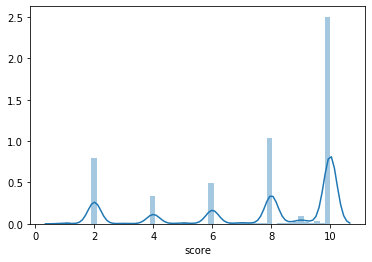

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############## Random Forest ##############

In [24]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest классификатор
clf_rf = RandomForestClassifier()



In [25]:
ytr[:10]

0     7.0
1    10.0
2     9.2
3     9.6
4     8.8
5    10.0
6    10.0
7    10.0
8     8.4
9     9.2
Name: score, dtype: float64

In [26]:
from sklearn import utils
ytr1 = ytr.astype('int')
yval1 = yval.astype('int')
utils.multiclass.type_of_target(ytr1)

'multiclass'

In [27]:
ytr1[:10]

0     7
1    10
2     9
3     9
4     8
5    10
6    10
7    10
8     8
9     9
Name: score, dtype: int32

In [28]:
#классификатор 
clf_rf.fit(Xtr, ytr1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
y_pred=clf_rf.predict(Xtr)
y_pred[:10]

array([ 7, 10,  9,  9,  8, 10, 10, 10,  8,  9])

In [30]:
y_pred_v=clf_rf.predict(Xval)
y_pred_v[:10]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [31]:
df = pd.DataFrame(list(zip(y_pred_v, yval)),
                                 columns = ['y_pred_v', 'yval'])
df.head(30)

,y_pred_v,yval
0,10,10.0
1,10,10.0
2,10,6.0
3,10,9.2
4,10,4.0
5,10,10.0
6,10,4.0
7,10,6.0
8,10,6.0
9,10,8.0


In [32]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(ytr1, y_pred)
print(accuracy)

0.9875589844715207


In [33]:
accuracy=accuracy_score(yval1, y_pred_v)
print(accuracy)

0.5624287704191465


In [34]:
from sklearn.metrics import classification_report

print(classification_report(ytr1, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99      1595
           2       0.99      0.99      0.99     60268
           3       1.00      0.99      0.99      1320
           4       0.99      0.98      0.99     26265
           5       1.00      1.00      1.00      2473
           6       0.99      0.98      0.99     38309
           7       1.00      1.00      1.00      3933
           8       0.99      0.97      0.98     81419
           9       1.00      0.99      1.00     13359
          10       0.98      1.00      0.99    187906

    accuracy                           0.99    416847
   macro avg       0.99      0.99      0.99    416847
weighted avg       0.99      0.99      0.99    416847



In [35]:
print(classification_report(yval1, y_pred_v))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        42
           2       0.52      0.53      0.52     14644
           3       0.00      0.00      0.00        76
           4       0.17      0.01      0.01      5814
           5       0.00      0.00      0.00       143
           6       0.24      0.03      0.05      9710
           7       0.00      0.00      0.00       856
           8       0.32      0.10      0.15     25476
           9       0.00      0.00      0.00      5284
          10       0.59      0.94      0.73     64307

    accuracy                           0.56    126352
   macro avg       0.18      0.16      0.15    126352
weighted avg       0.45      0.56      0.47    126352

